<a href="https://colab.research.google.com/github/samuramirez/cellmigration/blob/master/segmentation_1_class_cell_indiv_tiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Segmentation one class (cell)

##Mount Google Drive, install load packages

### Mount Google Drive (Colab can see Drive files) and authenticate so that we can interact with GCP via SDK

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# from google.colab import auth
# #This allows SDK to see and edit Google Drive files
# #SDK is required to interact with GCP
# auth.authenticate_user()

### Installing and loading packages 

In [3]:
#!nvidia-smi

In [4]:
import pandas as pd
#pip install --upgrade pandas

In [5]:
pd.__version__

'1.3.5'

In [6]:
pip install torch==1.7.1 torchvision==0.8.2

     |████████████████████████████████| 776.8 MB 15 kB/s 
     |████████████████████████████████| 12.8 MB 51.2 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.7.1 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.7.1 which is incompatible.


In [7]:
import torch
import torchvision
print(torch.__version__)


1.7.1


In [8]:
print(torch.version.cuda)

10.2


In [9]:
torch.cuda.is_available()

False

In [10]:
#torch.cuda.get_device_name(0)

In [11]:
#!pip install -q torch==1.7.0 torchvision

In [12]:
#!pip install fastai==2.0.13 --no-deps


In [13]:
#!pip install fastcore==1.0.13
!pip install fastcore

     |████████████████████████████████| 56 kB 2.1 MB/s 


In [14]:
import fastcore


In [15]:
#!pip install -Uqq fastbook

In [16]:
!pip install fastai --upgrade

     |████████████████████████████████| 189 kB 3.6 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [17]:
import fastai
fastai.__version__

'2.5.3'

In [18]:
#import fastbook
#fastbook.setup_book()

In [19]:
print(fastcore.__version__)


1.3.27


In [20]:
from fastai.vision.all import *

In [21]:
import imageio
from skimage.io import imread, imsave, imshow
from skimage.exposure import rescale_intensity
import os
import numpy as np
from pathlib import Path
import re
import ntpath

!ls

gdrive	sample_data


# Segmentation Parameters


##Basic Parameters
other shared settings between training and separation

In [22]:
segmentation_target = "Cell" #@param ["Nucleus", "Cell"]

#@markdown local folder is "content" when working in colab, may be different for GCP AI
local_folder='content' #@param {type:"string"}

#@markdown directory where models are stored in and will be exported to
modelsfolder = '/content/gdrive/Othercomputers/My PC/segmentation_iteration_testing/models/fastai' #@param {type:"string"}

# #@markdown local directory where preprocessed images and masks are stored for training
# local_dir='local_copy' #@param {type:"string"}
# !mkdir {local_dir}

## Image Preparation
shared settings between training and segmentation image/mask processing

In [23]:
#@markdown Number of slices (columns/rows) to divide input images into; for the math, pleast check https://www.desmos.com/calculator/t3cyflvlef
x_slices = 5 #@param {type:"integer"}
y_slices =  5 #@param {type:"integer"}
#@markdown dx, dy are the extra context around the segmented center in both directions
dx =  42#@param {type:"integer"}
dy =  32#@param {type:"integer"}
#@markdown x and y crop are how much to straight remove from the image to make the sizes able to be subdivided nicely
x_crop = 0 #@param {type:"integer"}
y_crop = 0 #@param {type:"integer"}

context_bounds = [dy,dx]*2 #assuming x and y symmetrical, not always true -- fix?
crop = [y_crop,x_crop]*2 #both of these are negative y, negative x, positive y, positive x

## Training-Specific Settings
parameters and paths only for training

In [24]:
#@markdown whether to fetch images from a zip file or a folder
imagezip = False #@param {type:"boolean"}

#@markdown location - zip file or folder - where input images are stored
training_images="/content/gdrive/Othercomputers/My PC/segmentation_iteration_testing/iter1/round6/images" #@param {type:"string"}
#@markdown input folder where masks are stored (will not be edited)
training_masks="/content/gdrive/Othercomputers/My PC/segmentation_iteration_testing/iter1/round6/masks" #@param {type:"string"}

local_image_dir = local_dir + '/images';
local_mask_dir = local_dir + '/masks';
!mkdir {local_image_dir}
!mkdir {local_mask_dir}

#@markdown base model that will be used to train from
inmodelname = 'seg_cell_062719_s_1_2_110619_bleb.pkl' #@param {type:"string"}
#@markdown where the model will be exported to after training
outmodelname = 'iter1_7_context_nogcp.pkl' #@param {type:"string"}



## Segmentation-Specific Settings
parameters and paths only for segmenting an experiment


In [25]:
#@markdown Path of the folder containing the movies in GCP bucket
segmentation_images="/content/gdrive/Othercomputers/My PC/segmentation_iteration_testing/iter1/round7/images"  #@param {type:"string"}
#@markdown name of the model used to segment
segment_model_name="iter1_6_context_fromsegbleb.pkl" #@param {type:"string"}
#@markdown path of the folder on GCP bucket where the masks will be deposited as a .zip file
segmentation_output_masks='/content/gdrive/Othercomputers/My PC/segmentation_iteration_testing/iter1/round7/input2' #@param {type:"string"}

local_segmentation_input_dir = local_dir + "/input_images"
local_segmentation_output_dir = local_dir + "/output_masks"
!mkdir {local_segmentation_input_dir}
!mkdir {local_segmentation_output_dir}

# Preparing data to train only on cell (from combined nuc-memb masks)

###Load masks for training

In [29]:
#get names of all masks
inmasknames=os.listdir(training_masks)

In [30]:
inmask=imread(training_masks+'/'+inmasknames[0])

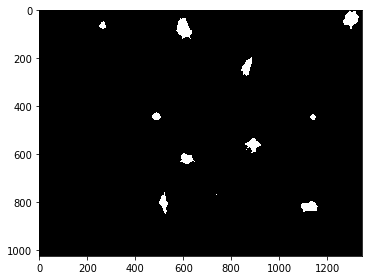

In [31]:
truncateMask = True;
if len(inmask.shape) == 2:
  truncateMask = False;
  imshow(inmask[:,:])
else:
  imshow(inmask[:,:,0])

In [32]:
#PREPARE MASKS AND AT THE END SAVE IN A DIFFERENT FOLDER
#DONE THIS WAY IN CASE WE ARE USING MASKS COMING FROM DIFFERENT TRAINING SET FOLDERS

#get only cells from combined (nuc,memb) mask
for imagename in inmasknames:
  print(imagename);
  mask=imread(training_masks+'/'+imagename)
  if truncateMask:
    mask=mask[:,:,0]
  if x_slices > 1 or y_slices > 1:
    if context_bounds == [0]*4:
      M = mask.shape[0]/y_slices
      N = mask.shape[1]/x_slices
      if int(M) != M or int(N) != N:
        raise Exception(f"ERROR: Mask with size {mask.shape[:1]} cannot be sliced into {x_slices} columns and {y_slices} rows");
      else:
        M = int(M)
        N = int(N)
      tiles = [mask[y:y+M,x:x+N] for x in range(0,mask.shape[1],N) for y in range(0,mask.shape[0],M)]
      for num,m in enumerate(tiles):
        imsave(local_mask_dir+'/'+os.path.splitext(imagename)[0] + f"-{num}" + ".TIF", m)
    else:
      print(mask.shape);
      M = (mask.shape[0]-context_bounds[0]-context_bounds[2]-crop[0]-crop[2])/y_slices;
      N = (mask.shape[1]-context_bounds[1]-context_bounds[3]-crop[1]-crop[3])/x_slices;
      print(M,N);
      # print(-context_bounds[1]-context_bounds[3]-crop[1]-crop[3])
      # print(im.shape);
      if int(M) != M or int(N) != N:
        raise Exception(f"ERROR: Mask with size {mask.shape[:2]} cannot be sliced into {x_slices} columns and {y_slices} rows\nwith context bounds of {context_bounds}; {M} and {N} not integers");
      else:
        M = int(M)
        N = int(N)
        sliced = True;
        tiles = [mask[y-context_bounds[0]:y+M+context_bounds[2],x-context_bounds[1]:x+N+context_bounds[3]] 
                for y in range(context_bounds[0]+crop[0],mask.shape[0]-crop[0]-crop[2]-context_bounds[0]-context_bounds[2],M) 
                for x in range(context_bounds[1]+crop[1],mask.shape[1]-crop[1]-crop[3]-context_bounds[1]-context_bounds[3],N)];
        print(len(tiles))
        imBounds = [[y-context_bounds[0],y+M+context_bounds[2],x-context_bounds[1],x+N+context_bounds[3]] 
                for y in range(context_bounds[0]+crop[0],mask.shape[0]-crop[0]-crop[2]-context_bounds[0]-context_bounds[2],M) 
                for x in range(context_bounds[1]+crop[1],mask.shape[1]-crop[1]-crop[3]-context_bounds[1]-context_bounds[3],N)];
        print(imBounds);
        print((context_bounds[0]+crop[0],mask.shape[0]-crop[0]-crop[2]-context_bounds[0]-context_bounds[2],M))
        print((context_bounds[1]+crop[1],mask.shape[1]-crop[1]-crop[3]-context_bounds[1]-context_bounds[3],N));

        # print((context_bounds[0]+crop[0],context_bounds[1]+crop[1]))
        # print(imBounds);
        for num,m in enumerate(tiles):
          # print(num);
          imsave(local_mask_dir+'/'+os.path.splitext(imagename)[0] + f"-{num}" + ".TIF", m)
  else:
    imsave(local_mask_dir+'/'+os.path.splitext(imagename)[0] + ".TIF", mask)

# #rename files
# for imagename in imagenames:
#   os.rename(training_masks_folder+'/'+imagename,training_masks_folder+'/'+imagename[:-4]+'.TIF')

# #get names of all masks
# imagenames=os.listdir(training_masks_folder)

# #copy individual images to maskdir
# !cp {training_masks_folder}/* {maskdir}

random_s11_t57.TIF
(1024, 1344)
192.0 252.0
25
[[0, 256, 0, 336], [0, 256, 252, 588], [0, 256, 504, 840], [0, 256, 756, 1092], [0, 256, 1008, 1344], [192, 448, 0, 336], [192, 448, 252, 588], [192, 448, 504, 840], [192, 448, 756, 1092], [192, 448, 1008, 1344], [384, 640, 0, 336], [384, 640, 252, 588], [384, 640, 504, 840], [384, 640, 756, 1092], [384, 640, 1008, 1344], [576, 832, 0, 336], [576, 832, 252, 588], [576, 832, 504, 840], [576, 832, 756, 1092], [576, 832, 1008, 1344], [768, 1024, 0, 336], [768, 1024, 252, 588], [768, 1024, 504, 840], [768, 1024, 756, 1092], [768, 1024, 1008, 1344]]
(32, 960, 192)
(42, 1260, 252)
random_s1_t157.TIF


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s11_t57-0.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s11_t57-5.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s11_t57-6.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s11_t57-7.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s11_t57-9.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s11_t57-10.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s11_t57-11.TIF is a low contrast image
/usr/local/lib/pyt

(1024, 1344)
192.0 252.0
25
[[0, 256, 0, 336], [0, 256, 252, 588], [0, 256, 504, 840], [0, 256, 756, 1092], [0, 256, 1008, 1344], [192, 448, 0, 336], [192, 448, 252, 588], [192, 448, 504, 840], [192, 448, 756, 1092], [192, 448, 1008, 1344], [384, 640, 0, 336], [384, 640, 252, 588], [384, 640, 504, 840], [384, 640, 756, 1092], [384, 640, 1008, 1344], [576, 832, 0, 336], [576, 832, 252, 588], [576, 832, 504, 840], [576, 832, 756, 1092], [576, 832, 1008, 1344], [768, 1024, 0, 336], [768, 1024, 252, 588], [768, 1024, 504, 840], [768, 1024, 756, 1092], [768, 1024, 1008, 1344]]
(32, 960, 192)
(42, 1260, 252)
random_s7_t76.TIF


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s1_t157-2.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s1_t157-3.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s1_t157-5.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s1_t157-6.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s1_t157-7.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s1_t157-14.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s1_t157-18.TIF is a low contrast image


(1024, 1344)
192.0 252.0
25
[[0, 256, 0, 336], [0, 256, 252, 588], [0, 256, 504, 840], [0, 256, 756, 1092], [0, 256, 1008, 1344], [192, 448, 0, 336], [192, 448, 252, 588], [192, 448, 504, 840], [192, 448, 756, 1092], [192, 448, 1008, 1344], [384, 640, 0, 336], [384, 640, 252, 588], [384, 640, 504, 840], [384, 640, 756, 1092], [384, 640, 1008, 1344], [576, 832, 0, 336], [576, 832, 252, 588], [576, 832, 504, 840], [576, 832, 756, 1092], [576, 832, 1008, 1344], [768, 1024, 0, 336], [768, 1024, 252, 588], [768, 1024, 504, 840], [768, 1024, 756, 1092], [768, 1024, 1008, 1344]]
(32, 960, 192)
(42, 1260, 252)
random_s2_t125.TIF


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s7_t76-2.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s7_t76-3.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s7_t76-7.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s7_t76-8.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s7_t76-9.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s7_t76-10.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s7_t76-11.TIF is a low contrast image
/usr/local/lib/python3.7/

(1024, 1344)
192.0 252.0
25
[[0, 256, 0, 336], [0, 256, 252, 588], [0, 256, 504, 840], [0, 256, 756, 1092], [0, 256, 1008, 1344], [192, 448, 0, 336], [192, 448, 252, 588], [192, 448, 504, 840], [192, 448, 756, 1092], [192, 448, 1008, 1344], [384, 640, 0, 336], [384, 640, 252, 588], [384, 640, 504, 840], [384, 640, 756, 1092], [384, 640, 1008, 1344], [576, 832, 0, 336], [576, 832, 252, 588], [576, 832, 504, 840], [576, 832, 756, 1092], [576, 832, 1008, 1344], [768, 1024, 0, 336], [768, 1024, 252, 588], [768, 1024, 504, 840], [768, 1024, 756, 1092], [768, 1024, 1008, 1344]]
(32, 960, 192)
(42, 1260, 252)
random_s8_t51.TIF


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s2_t125-10.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s2_t125-11.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s2_t125-12.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s2_t125-14.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s2_t125-15.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s2_t125-16.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s2_t125-17.TIF is a low contrast image
/usr/local/li

(1024, 1344)
192.0 252.0
25
[[0, 256, 0, 336], [0, 256, 252, 588], [0, 256, 504, 840], [0, 256, 756, 1092], [0, 256, 1008, 1344], [192, 448, 0, 336], [192, 448, 252, 588], [192, 448, 504, 840], [192, 448, 756, 1092], [192, 448, 1008, 1344], [384, 640, 0, 336], [384, 640, 252, 588], [384, 640, 504, 840], [384, 640, 756, 1092], [384, 640, 1008, 1344], [576, 832, 0, 336], [576, 832, 252, 588], [576, 832, 504, 840], [576, 832, 756, 1092], [576, 832, 1008, 1344], [768, 1024, 0, 336], [768, 1024, 252, 588], [768, 1024, 504, 840], [768, 1024, 756, 1092], [768, 1024, 1008, 1344]]
(32, 960, 192)
(42, 1260, 252)
random_s1_t138.TIF


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s8_t51-3.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s8_t51-4.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s8_t51-6.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s8_t51-8.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s8_t51-9.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s8_t51-10.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s8_t51-11.TIF is a low contrast image
/usr/local/lib/python3.7/

(1024, 1344)
192.0 252.0
25
[[0, 256, 0, 336], [0, 256, 252, 588], [0, 256, 504, 840], [0, 256, 756, 1092], [0, 256, 1008, 1344], [192, 448, 0, 336], [192, 448, 252, 588], [192, 448, 504, 840], [192, 448, 756, 1092], [192, 448, 1008, 1344], [384, 640, 0, 336], [384, 640, 252, 588], [384, 640, 504, 840], [384, 640, 756, 1092], [384, 640, 1008, 1344], [576, 832, 0, 336], [576, 832, 252, 588], [576, 832, 504, 840], [576, 832, 756, 1092], [576, 832, 1008, 1344], [768, 1024, 0, 336], [768, 1024, 252, 588], [768, 1024, 504, 840], [768, 1024, 756, 1092], [768, 1024, 1008, 1344]]
(32, 960, 192)
(42, 1260, 252)
random_s4_t63.TIF
(1024, 1344)
192.0 252.0
25
[[0, 256, 0, 336], [0, 256, 252, 588], [0, 256, 504, 840], [0, 256, 756, 1092], [0, 256, 1008, 1344], [192, 448, 0, 336], [192, 448, 252, 588], [192, 448, 504, 840], [192, 448, 756, 1092], [192, 448, 1008, 1344], [384, 640, 0, 336], [384, 640, 252, 588], [384, 640, 504, 840], [384, 640, 756, 1092], [384, 640, 1008, 1344], [576, 832, 0, 336], 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s1_t138-2.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s1_t138-3.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s1_t138-5.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s1_t138-6.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s1_t138-14.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s4_t63-2.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s4_t63-3.TIF is a low contrast image
/usr/local/lib/python

random_s5_t39.TIF
(1024, 1344)
192.0 252.0
25
[[0, 256, 0, 336], [0, 256, 252, 588], [0, 256, 504, 840], [0, 256, 756, 1092], [0, 256, 1008, 1344], [192, 448, 0, 336], [192, 448, 252, 588], [192, 448, 504, 840], [192, 448, 756, 1092], [192, 448, 1008, 1344], [384, 640, 0, 336], [384, 640, 252, 588], [384, 640, 504, 840], [384, 640, 756, 1092], [384, 640, 1008, 1344], [576, 832, 0, 336], [576, 832, 252, 588], [576, 832, 504, 840], [576, 832, 756, 1092], [576, 832, 1008, 1344], [768, 1024, 0, 336], [768, 1024, 252, 588], [768, 1024, 504, 840], [768, 1024, 756, 1092], [768, 1024, 1008, 1344]]
(32, 960, 192)
(42, 1260, 252)
random_s6_t110.TIF


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s5_t39-1.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s5_t39-2.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s5_t39-6.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s5_t39-7.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s5_t39-10.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s5_t39-11.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s5_t39-12.TIF is a low contrast image
/usr/local/lib/python3.7

(1024, 1344)
192.0 252.0
25
[[0, 256, 0, 336], [0, 256, 252, 588], [0, 256, 504, 840], [0, 256, 756, 1092], [0, 256, 1008, 1344], [192, 448, 0, 336], [192, 448, 252, 588], [192, 448, 504, 840], [192, 448, 756, 1092], [192, 448, 1008, 1344], [384, 640, 0, 336], [384, 640, 252, 588], [384, 640, 504, 840], [384, 640, 756, 1092], [384, 640, 1008, 1344], [576, 832, 0, 336], [576, 832, 252, 588], [576, 832, 504, 840], [576, 832, 756, 1092], [576, 832, 1008, 1344], [768, 1024, 0, 336], [768, 1024, 252, 588], [768, 1024, 504, 840], [768, 1024, 756, 1092], [768, 1024, 1008, 1344]]
(32, 960, 192)
(42, 1260, 252)
random_s5_t135.TIF


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s6_t110-2.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s6_t110-7.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s6_t110-9.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s6_t110-10.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s6_t110-12.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s6_t110-13.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s6_t110-14.TIF is a low contrast image
/usr/local/lib/p

(1024, 1344)
192.0 252.0
25
[[0, 256, 0, 336], [0, 256, 252, 588], [0, 256, 504, 840], [0, 256, 756, 1092], [0, 256, 1008, 1344], [192, 448, 0, 336], [192, 448, 252, 588], [192, 448, 504, 840], [192, 448, 756, 1092], [192, 448, 1008, 1344], [384, 640, 0, 336], [384, 640, 252, 588], [384, 640, 504, 840], [384, 640, 756, 1092], [384, 640, 1008, 1344], [576, 832, 0, 336], [576, 832, 252, 588], [576, 832, 504, 840], [576, 832, 756, 1092], [576, 832, 1008, 1344], [768, 1024, 0, 336], [768, 1024, 252, 588], [768, 1024, 504, 840], [768, 1024, 756, 1092], [768, 1024, 1008, 1344]]
(32, 960, 192)
(42, 1260, 252)
random_s3_t216.TIF
(1024, 1344)
192.0 252.0
25
[[0, 256, 0, 336], [0, 256, 252, 588], [0, 256, 504, 840], [0, 256, 756, 1092], [0, 256, 1008, 1344], [192, 448, 0, 336], [192, 448, 252, 588], [192, 448, 504, 840], [192, 448, 756, 1092], [192, 448, 1008, 1344], [384, 640, 0, 336], [384, 640, 252, 588], [384, 640, 504, 840], [384, 640, 756, 1092], [384, 640, 1008, 1344], [576, 832, 0, 336],

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s5_t135-0.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s5_t135-1.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s5_t135-2.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s5_t135-5.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s5_t135-6.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s5_t135-7.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s5_t135-10.TIF is a low contrast image
/usr/local/lib/pyth

migration1_s13_t1.TIF
(1024, 1344)
192.0 252.0
25
[[0, 256, 0, 336], [0, 256, 252, 588], [0, 256, 504, 840], [0, 256, 756, 1092], [0, 256, 1008, 1344], [192, 448, 0, 336], [192, 448, 252, 588], [192, 448, 504, 840], [192, 448, 756, 1092], [192, 448, 1008, 1344], [384, 640, 0, 336], [384, 640, 252, 588], [384, 640, 504, 840], [384, 640, 756, 1092], [384, 640, 1008, 1344], [576, 832, 0, 336], [576, 832, 252, 588], [576, 832, 504, 840], [576, 832, 756, 1092], [576, 832, 1008, 1344], [768, 1024, 0, 336], [768, 1024, 252, 588], [768, 1024, 504, 840], [768, 1024, 756, 1092], [768, 1024, 1008, 1344]]
(32, 960, 192)
(42, 1260, 252)
random_s9_t171.TIF


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s13_t1-19.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s13_t1-20.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s13_t1-21.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s13_t1-24.TIF is a low contrast image


(1024, 1344)
192.0 252.0
25
[[0, 256, 0, 336], [0, 256, 252, 588], [0, 256, 504, 840], [0, 256, 756, 1092], [0, 256, 1008, 1344], [192, 448, 0, 336], [192, 448, 252, 588], [192, 448, 504, 840], [192, 448, 756, 1092], [192, 448, 1008, 1344], [384, 640, 0, 336], [384, 640, 252, 588], [384, 640, 504, 840], [384, 640, 756, 1092], [384, 640, 1008, 1344], [576, 832, 0, 336], [576, 832, 252, 588], [576, 832, 504, 840], [576, 832, 756, 1092], [576, 832, 1008, 1344], [768, 1024, 0, 336], [768, 1024, 252, 588], [768, 1024, 504, 840], [768, 1024, 756, 1092], [768, 1024, 1008, 1344]]
(32, 960, 192)
(42, 1260, 252)
migration1_s7_t7.TIF
(1024, 1344)
192.0 252.0
25
[[0, 256, 0, 336], [0, 256, 252, 588], [0, 256, 504, 840], [0, 256, 756, 1092], [0, 256, 1008, 1344], [192, 448, 0, 336], [192, 448, 252, 588], [192, 448, 504, 840], [192, 448, 756, 1092], [192, 448, 1008, 1344], [384, 640, 0, 336], [384, 640, 252, 588], [384, 640, 504, 840], [384, 640, 756, 1092], [384, 640, 1008, 1344], [576, 832, 0, 336

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s9_t171-4.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s9_t171-9.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s9_t171-10.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s9_t171-11.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s9_t171-12.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s9_t171-13.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s9_t171-14.TIF is a low contrast image
/usr/local/lib/

migration1_s10_t6.TIF
(1024, 1344)
192.0 252.0
25
[[0, 256, 0, 336], [0, 256, 252, 588], [0, 256, 504, 840], [0, 256, 756, 1092], [0, 256, 1008, 1344], [192, 448, 0, 336], [192, 448, 252, 588], [192, 448, 504, 840], [192, 448, 756, 1092], [192, 448, 1008, 1344], [384, 640, 0, 336], [384, 640, 252, 588], [384, 640, 504, 840], [384, 640, 756, 1092], [384, 640, 1008, 1344], [576, 832, 0, 336], [576, 832, 252, 588], [576, 832, 504, 840], [576, 832, 756, 1092], [576, 832, 1008, 1344], [768, 1024, 0, 336], [768, 1024, 252, 588], [768, 1024, 504, 840], [768, 1024, 756, 1092], [768, 1024, 1008, 1344]]
(32, 960, 192)
(42, 1260, 252)
random_s1_t45.TIF


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s10_t6-14.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s10_t6-15.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s10_t6-20.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s10_t6-21.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s10_t6-22.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s10_t6-23.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s10_t6-24.TIF is a low contras

(1024, 1344)
192.0 252.0
25
[[0, 256, 0, 336], [0, 256, 252, 588], [0, 256, 504, 840], [0, 256, 756, 1092], [0, 256, 1008, 1344], [192, 448, 0, 336], [192, 448, 252, 588], [192, 448, 504, 840], [192, 448, 756, 1092], [192, 448, 1008, 1344], [384, 640, 0, 336], [384, 640, 252, 588], [384, 640, 504, 840], [384, 640, 756, 1092], [384, 640, 1008, 1344], [576, 832, 0, 336], [576, 832, 252, 588], [576, 832, 504, 840], [576, 832, 756, 1092], [576, 832, 1008, 1344], [768, 1024, 0, 336], [768, 1024, 252, 588], [768, 1024, 504, 840], [768, 1024, 756, 1092], [768, 1024, 1008, 1344]]
(32, 960, 192)
(42, 1260, 252)
random_s3_t104.TIF
(1024, 1344)
192.0 252.0
25
[[0, 256, 0, 336], [0, 256, 252, 588], [0, 256, 504, 840], [0, 256, 756, 1092], [0, 256, 1008, 1344], [192, 448, 0, 336], [192, 448, 252, 588], [192, 448, 504, 840], [192, 448, 756, 1092], [192, 448, 1008, 1344], [384, 640, 0, 336], [384, 640, 252, 588], [384, 640, 504, 840], [384, 640, 756, 1092], [384, 640, 1008, 1344], [576, 832, 0, 336],

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s3_t104-2.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s3_t104-7.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s3_t104-11.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s3_t104-12.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s3_t104-22.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s3_t104-23.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s3_t104-24.TIF is a low contrast image


random_s6_t220.TIF
(1024, 1344)
192.0 252.0
25
[[0, 256, 0, 336], [0, 256, 252, 588], [0, 256, 504, 840], [0, 256, 756, 1092], [0, 256, 1008, 1344], [192, 448, 0, 336], [192, 448, 252, 588], [192, 448, 504, 840], [192, 448, 756, 1092], [192, 448, 1008, 1344], [384, 640, 0, 336], [384, 640, 252, 588], [384, 640, 504, 840], [384, 640, 756, 1092], [384, 640, 1008, 1344], [576, 832, 0, 336], [576, 832, 252, 588], [576, 832, 504, 840], [576, 832, 756, 1092], [576, 832, 1008, 1344], [768, 1024, 0, 336], [768, 1024, 252, 588], [768, 1024, 504, 840], [768, 1024, 756, 1092], [768, 1024, 1008, 1344]]
(32, 960, 192)
(42, 1260, 252)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s6_t220-2.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s6_t220-3.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s6_t220-6.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s6_t220-7.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s6_t220-9.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s6_t220-12.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s6_t220-13.TIF is a low contrast image
/usr/local/lib/pyt

random_s11_t119.TIF
(1024, 1344)
192.0 252.0
25
[[0, 256, 0, 336], [0, 256, 252, 588], [0, 256, 504, 840], [0, 256, 756, 1092], [0, 256, 1008, 1344], [192, 448, 0, 336], [192, 448, 252, 588], [192, 448, 504, 840], [192, 448, 756, 1092], [192, 448, 1008, 1344], [384, 640, 0, 336], [384, 640, 252, 588], [384, 640, 504, 840], [384, 640, 756, 1092], [384, 640, 1008, 1344], [576, 832, 0, 336], [576, 832, 252, 588], [576, 832, 504, 840], [576, 832, 756, 1092], [576, 832, 1008, 1344], [768, 1024, 0, 336], [768, 1024, 252, 588], [768, 1024, 504, 840], [768, 1024, 756, 1092], [768, 1024, 1008, 1344]]
(32, 960, 192)
(42, 1260, 252)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s11_t119-0.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s11_t119-5.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s11_t119-6.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s11_t119-7.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s11_t119-9.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s11_t119-10.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random_s11_t119-14.TIF is a low contrast image
/usr/local/

migration1_s1_t5.TIF
(1024, 1344)
192.0 252.0
25
[[0, 256, 0, 336], [0, 256, 252, 588], [0, 256, 504, 840], [0, 256, 756, 1092], [0, 256, 1008, 1344], [192, 448, 0, 336], [192, 448, 252, 588], [192, 448, 504, 840], [192, 448, 756, 1092], [192, 448, 1008, 1344], [384, 640, 0, 336], [384, 640, 252, 588], [384, 640, 504, 840], [384, 640, 756, 1092], [384, 640, 1008, 1344], [576, 832, 0, 336], [576, 832, 252, 588], [576, 832, 504, 840], [576, 832, 756, 1092], [576, 832, 1008, 1344], [768, 1024, 0, 336], [768, 1024, 252, 588], [768, 1024, 504, 840], [768, 1024, 756, 1092], [768, 1024, 1008, 1344]]
(32, 960, 192)
(42, 1260, 252)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s1_t5-19.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s9_t6-3.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s9_t6-4.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s9_t6-5.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s9_t6-8.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s9_t6-10.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s9_t6-11.TIF is a low contrast image
/us

migration1_s9_t6.TIF
(1024, 1344)
192.0 252.0
25
[[0, 256, 0, 336], [0, 256, 252, 588], [0, 256, 504, 840], [0, 256, 756, 1092], [0, 256, 1008, 1344], [192, 448, 0, 336], [192, 448, 252, 588], [192, 448, 504, 840], [192, 448, 756, 1092], [192, 448, 1008, 1344], [384, 640, 0, 336], [384, 640, 252, 588], [384, 640, 504, 840], [384, 640, 756, 1092], [384, 640, 1008, 1344], [576, 832, 0, 336], [576, 832, 252, 588], [576, 832, 504, 840], [576, 832, 756, 1092], [576, 832, 1008, 1344], [768, 1024, 0, 336], [768, 1024, 252, 588], [768, 1024, 504, 840], [768, 1024, 756, 1092], [768, 1024, 1008, 1344]]
(32, 960, 192)
(42, 1260, 252)
migration1_s12_t9.TIF
(1024, 1344)
192.0 252.0
25
[[0, 256, 0, 336], [0, 256, 252, 588], [0, 256, 504, 840], [0, 256, 756, 1092], [0, 256, 1008, 1344], [192, 448, 0, 336], [192, 448, 252, 588], [192, 448, 504, 840], [192, 448, 756, 1092], [192, 448, 1008, 1344], [384, 640, 0, 336], [384, 640, 252, 588], [384, 640, 504, 840], [384, 640, 756, 1092], [384, 640, 1008, 13

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s12_t9-2.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s12_t9-11.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s12_t9-16.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s12_t9-17.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s12_t9-18.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s12_t9-21.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s12_t9-22.TIF is a low contrast

migration1_s3_t11.TIF
(1024, 1344)
192.0 252.0
25
[[0, 256, 0, 336], [0, 256, 252, 588], [0, 256, 504, 840], [0, 256, 756, 1092], [0, 256, 1008, 1344], [192, 448, 0, 336], [192, 448, 252, 588], [192, 448, 504, 840], [192, 448, 756, 1092], [192, 448, 1008, 1344], [384, 640, 0, 336], [384, 640, 252, 588], [384, 640, 504, 840], [384, 640, 756, 1092], [384, 640, 1008, 1344], [576, 832, 0, 336], [576, 832, 252, 588], [576, 832, 504, 840], [576, 832, 756, 1092], [576, 832, 1008, 1344], [768, 1024, 0, 336], [768, 1024, 252, 588], [768, 1024, 504, 840], [768, 1024, 756, 1092], [768, 1024, 1008, 1344]]
(32, 960, 192)
(42, 1260, 252)
migration1_s4_t48.TIF


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s3_t11-22.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s3_t11-23.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s3_t11-24.TIF is a low contrast image


(1024, 1344)
192.0 252.0
25
[[0, 256, 0, 336], [0, 256, 252, 588], [0, 256, 504, 840], [0, 256, 756, 1092], [0, 256, 1008, 1344], [192, 448, 0, 336], [192, 448, 252, 588], [192, 448, 504, 840], [192, 448, 756, 1092], [192, 448, 1008, 1344], [384, 640, 0, 336], [384, 640, 252, 588], [384, 640, 504, 840], [384, 640, 756, 1092], [384, 640, 1008, 1344], [576, 832, 0, 336], [576, 832, 252, 588], [576, 832, 504, 840], [576, 832, 756, 1092], [576, 832, 1008, 1344], [768, 1024, 0, 336], [768, 1024, 252, 588], [768, 1024, 504, 840], [768, 1024, 756, 1092], [768, 1024, 1008, 1344]]
(32, 960, 192)
(42, 1260, 252)
migration1_s5_t29.TIF
(1024, 1344)
192.0 252.0
25
[[0, 256, 0, 336], [0, 256, 252, 588], [0, 256, 504, 840], [0, 256, 756, 1092], [0, 256, 1008, 1344], [192, 448, 0, 336], [192, 448, 252, 588], [192, 448, 504, 840], [192, 448, 756, 1092], [192, 448, 1008, 1344], [384, 640, 0, 336], [384, 640, 252, 588], [384, 640, 504, 840], [384, 640, 756, 1092], [384, 640, 1008, 1344], [576, 832, 0, 33

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s4_t48-3.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s4_t48-4.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s4_t48-8.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s4_t48-10.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s4_t48-11.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s4_t48-13.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s4_t48-15.TIF is a low contrast i

migration1_s6_t15.TIF
(1024, 1344)
192.0 252.0
25
[[0, 256, 0, 336], [0, 256, 252, 588], [0, 256, 504, 840], [0, 256, 756, 1092], [0, 256, 1008, 1344], [192, 448, 0, 336], [192, 448, 252, 588], [192, 448, 504, 840], [192, 448, 756, 1092], [192, 448, 1008, 1344], [384, 640, 0, 336], [384, 640, 252, 588], [384, 640, 504, 840], [384, 640, 756, 1092], [384, 640, 1008, 1344], [576, 832, 0, 336], [576, 832, 252, 588], [576, 832, 504, 840], [576, 832, 756, 1092], [576, 832, 1008, 1344], [768, 1024, 0, 336], [768, 1024, 252, 588], [768, 1024, 504, 840], [768, 1024, 756, 1092], [768, 1024, 1008, 1344]]
(32, 960, 192)
(42, 1260, 252)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s6_t15-1.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s6_t15-2.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s6_t15-5.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s6_t15-9.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s6_t15-10.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s6_t15-15.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s6_t15-16.TIF is a low contrast im

migration1_s8_t20.TIF
(1024, 1344)
192.0 252.0
25
[[0, 256, 0, 336], [0, 256, 252, 588], [0, 256, 504, 840], [0, 256, 756, 1092], [0, 256, 1008, 1344], [192, 448, 0, 336], [192, 448, 252, 588], [192, 448, 504, 840], [192, 448, 756, 1092], [192, 448, 1008, 1344], [384, 640, 0, 336], [384, 640, 252, 588], [384, 640, 504, 840], [384, 640, 756, 1092], [384, 640, 1008, 1344], [576, 832, 0, 336], [576, 832, 252, 588], [576, 832, 504, 840], [576, 832, 756, 1092], [576, 832, 1008, 1344], [768, 1024, 0, 336], [768, 1024, 252, 588], [768, 1024, 504, 840], [768, 1024, 756, 1092], [768, 1024, 1008, 1344]]
(32, 960, 192)
(42, 1260, 252)
migration1_s11_t49.TIF
(1024, 1344)
192.0 252.0
25
[[0, 256, 0, 336], [0, 256, 252, 588], [0, 256, 504, 840], [0, 256, 756, 1092], [0, 256, 1008, 1344], [192, 448, 0, 336], [192, 448, 252, 588], [192, 448, 504, 840], [192, 448, 756, 1092], [192, 448, 1008, 1344], [384, 640, 0, 336], [384, 640, 252, 588], [384, 640, 504, 840], [384, 640, 756, 1092], [384, 640, 1008, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s8_t20-0.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s8_t20-5.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s8_t20-11.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s8_t20-12.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s8_t20-13.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s8_t20-16.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/migration1_s8_t20-19.TIF is a low contrast 

random2_s16_t8.TIF
(1024, 1344)
192.0 252.0
25
[[0, 256, 0, 336], [0, 256, 252, 588], [0, 256, 504, 840], [0, 256, 756, 1092], [0, 256, 1008, 1344], [192, 448, 0, 336], [192, 448, 252, 588], [192, 448, 504, 840], [192, 448, 756, 1092], [192, 448, 1008, 1344], [384, 640, 0, 336], [384, 640, 252, 588], [384, 640, 504, 840], [384, 640, 756, 1092], [384, 640, 1008, 1344], [576, 832, 0, 336], [576, 832, 252, 588], [576, 832, 504, 840], [576, 832, 756, 1092], [576, 832, 1008, 1344], [768, 1024, 0, 336], [768, 1024, 252, 588], [768, 1024, 504, 840], [768, 1024, 756, 1092], [768, 1024, 1008, 1344]]
(32, 960, 192)
(42, 1260, 252)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random2_s16_t8-6.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random2_s16_t8-11.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random2_s16_t8-12.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random2_s16_t8-18.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random2_s16_t8-22.TIF is a low contrast image


random2_s2_t38.TIF
(1024, 1344)
192.0 252.0
25
[[0, 256, 0, 336], [0, 256, 252, 588], [0, 256, 504, 840], [0, 256, 756, 1092], [0, 256, 1008, 1344], [192, 448, 0, 336], [192, 448, 252, 588], [192, 448, 504, 840], [192, 448, 756, 1092], [192, 448, 1008, 1344], [384, 640, 0, 336], [384, 640, 252, 588], [384, 640, 504, 840], [384, 640, 756, 1092], [384, 640, 1008, 1344], [576, 832, 0, 336], [576, 832, 252, 588], [576, 832, 504, 840], [576, 832, 756, 1092], [576, 832, 1008, 1344], [768, 1024, 0, 336], [768, 1024, 252, 588], [768, 1024, 504, 840], [768, 1024, 756, 1092], [768, 1024, 1008, 1344]]
(32, 960, 192)
(42, 1260, 252)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random2_s2_t38-11.TIF is a low contrast image


random2_s14_t83.TIF
(1024, 1344)
192.0 252.0
25
[[0, 256, 0, 336], [0, 256, 252, 588], [0, 256, 504, 840], [0, 256, 756, 1092], [0, 256, 1008, 1344], [192, 448, 0, 336], [192, 448, 252, 588], [192, 448, 504, 840], [192, 448, 756, 1092], [192, 448, 1008, 1344], [384, 640, 0, 336], [384, 640, 252, 588], [384, 640, 504, 840], [384, 640, 756, 1092], [384, 640, 1008, 1344], [576, 832, 0, 336], [576, 832, 252, 588], [576, 832, 504, 840], [576, 832, 756, 1092], [576, 832, 1008, 1344], [768, 1024, 0, 336], [768, 1024, 252, 588], [768, 1024, 504, 840], [768, 1024, 756, 1092], [768, 1024, 1008, 1344]]
(32, 960, 192)
(42, 1260, 252)
random2_s6_t13.TIF
(1024, 1344)
192.0 252.0
25
[[0, 256, 0, 336], [0, 256, 252, 588], [0, 256, 504, 840], [0, 256, 756, 1092], [0, 256, 1008, 1344], [192, 448, 0, 336], [192, 448, 252, 588], [192, 448, 504, 840], [192, 448, 756, 1092], [192, 448, 1008, 1344], [384, 640, 0, 336], [384, 640, 252, 588], [384, 640, 504, 840], [384, 640, 756, 1092], [384, 640, 1008, 1344],

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random2_s6_t13-6.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random2_s6_t13-12.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random2_s8_t11-2.TIF is a low contrast image



(1024, 1344)
192.0 252.0
25
[[0, 256, 0, 336], [0, 256, 252, 588], [0, 256, 504, 840], [0, 256, 756, 1092], [0, 256, 1008, 1344], [192, 448, 0, 336], [192, 448, 252, 588], [192, 448, 504, 840], [192, 448, 756, 1092], [192, 448, 1008, 1344], [384, 640, 0, 336], [384, 640, 252, 588], [384, 640, 504, 840], [384, 640, 756, 1092], [384, 640, 1008, 1344], [576, 832, 0, 336], [576, 832, 252, 588], [576, 832, 504, 840], [576, 832, 756, 1092], [576, 832, 1008, 1344], [768, 1024, 0, 336], [768, 1024, 252, 588], [768, 1024, 504, 840], [768, 1024, 756, 1092], [768, 1024, 1008, 1344]]
(32, 960, 192)
(42, 1260, 252)
random2_s8_t43.TIF


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random2_s8_t11-17.TIF is a low contrast image


(1024, 1344)
192.0 252.0
25
[[0, 256, 0, 336], [0, 256, 252, 588], [0, 256, 504, 840], [0, 256, 756, 1092], [0, 256, 1008, 1344], [192, 448, 0, 336], [192, 448, 252, 588], [192, 448, 504, 840], [192, 448, 756, 1092], [192, 448, 1008, 1344], [384, 640, 0, 336], [384, 640, 252, 588], [384, 640, 504, 840], [384, 640, 756, 1092], [384, 640, 1008, 1344], [576, 832, 0, 336], [576, 832, 252, 588], [576, 832, 504, 840], [576, 832, 756, 1092], [576, 832, 1008, 1344], [768, 1024, 0, 336], [768, 1024, 252, 588], [768, 1024, 504, 840], [768, 1024, 756, 1092], [768, 1024, 1008, 1344]]
(32, 960, 192)
(42, 1260, 252)
random2_s10_t28.TIF


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random2_s8_t43-17.TIF is a low contrast image


(1024, 1344)
192.0 252.0
25
[[0, 256, 0, 336], [0, 256, 252, 588], [0, 256, 504, 840], [0, 256, 756, 1092], [0, 256, 1008, 1344], [192, 448, 0, 336], [192, 448, 252, 588], [192, 448, 504, 840], [192, 448, 756, 1092], [192, 448, 1008, 1344], [384, 640, 0, 336], [384, 640, 252, 588], [384, 640, 504, 840], [384, 640, 756, 1092], [384, 640, 1008, 1344], [576, 832, 0, 336], [576, 832, 252, 588], [576, 832, 504, 840], [576, 832, 756, 1092], [576, 832, 1008, 1344], [768, 1024, 0, 336], [768, 1024, 252, 588], [768, 1024, 504, 840], [768, 1024, 756, 1092], [768, 1024, 1008, 1344]]
(32, 960, 192)
(42, 1260, 252)
random2_s14_t34.TIF
(1024, 1344)
192.0 252.0
25
[[0, 256, 0, 336], [0, 256, 252, 588], [0, 256, 504, 840], [0, 256, 756, 1092], [0, 256, 1008, 1344], [192, 448, 0, 336], [192, 448, 252, 588], [192, 448, 504, 840], [192, 448, 756, 1092], [192, 448, 1008, 1344], [384, 640, 0, 336], [384, 640, 252, 588], [384, 640, 504, 840], [384, 640, 756, 1092], [384, 640, 1008, 1344], [576, 832, 0, 336]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random2_s1_t105-10.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random2_s1_t105-13.TIF is a low contrast image


(1024, 1344)
192.0 252.0
25
[[0, 256, 0, 336], [0, 256, 252, 588], [0, 256, 504, 840], [0, 256, 756, 1092], [0, 256, 1008, 1344], [192, 448, 0, 336], [192, 448, 252, 588], [192, 448, 504, 840], [192, 448, 756, 1092], [192, 448, 1008, 1344], [384, 640, 0, 336], [384, 640, 252, 588], [384, 640, 504, 840], [384, 640, 756, 1092], [384, 640, 1008, 1344], [576, 832, 0, 336], [576, 832, 252, 588], [576, 832, 504, 840], [576, 832, 756, 1092], [576, 832, 1008, 1344], [768, 1024, 0, 336], [768, 1024, 252, 588], [768, 1024, 504, 840], [768, 1024, 756, 1092], [768, 1024, 1008, 1344]]
(32, 960, 192)
(42, 1260, 252)
random2_s11_t219.TIF


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random2_s3_t192-4.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random2_s3_t192-8.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random2_s3_t192-9.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random2_s3_t192-11.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random2_s3_t192-14.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random2_s3_t192-18.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random2_s3_t192-19.TIF is a low contrast image
/usr/loca

(1024, 1344)
192.0 252.0
25
[[0, 256, 0, 336], [0, 256, 252, 588], [0, 256, 504, 840], [0, 256, 756, 1092], [0, 256, 1008, 1344], [192, 448, 0, 336], [192, 448, 252, 588], [192, 448, 504, 840], [192, 448, 756, 1092], [192, 448, 1008, 1344], [384, 640, 0, 336], [384, 640, 252, 588], [384, 640, 504, 840], [384, 640, 756, 1092], [384, 640, 1008, 1344], [576, 832, 0, 336], [576, 832, 252, 588], [576, 832, 504, 840], [576, 832, 756, 1092], [576, 832, 1008, 1344], [768, 1024, 0, 336], [768, 1024, 252, 588], [768, 1024, 504, 840], [768, 1024, 756, 1092], [768, 1024, 1008, 1344]]
(32, 960, 192)
(42, 1260, 252)
random2_s14_t150.TIF


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random2_s11_t219-2.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random2_s11_t219-3.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random2_s11_t219-4.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random2_s11_t219-8.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random2_s11_t219-9.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random2_s11_t219-13.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: local_copy/masks/random2_s11_t219-14.TIF is a low contrast image
/usr

(1024, 1344)
192.0 252.0
25
[[0, 256, 0, 336], [0, 256, 252, 588], [0, 256, 504, 840], [0, 256, 756, 1092], [0, 256, 1008, 1344], [192, 448, 0, 336], [192, 448, 252, 588], [192, 448, 504, 840], [192, 448, 756, 1092], [192, 448, 1008, 1344], [384, 640, 0, 336], [384, 640, 252, 588], [384, 640, 504, 840], [384, 640, 756, 1092], [384, 640, 1008, 1344], [576, 832, 0, 336], [576, 832, 252, 588], [576, 832, 504, 840], [576, 832, 756, 1092], [576, 832, 1008, 1344], [768, 1024, 0, 336], [768, 1024, 252, 588], [768, 1024, 504, 840], [768, 1024, 756, 1092], [768, 1024, 1008, 1344]]
(32, 960, 192)
(42, 1260, 252)


In [33]:
#get names of all masks
localmasknames=os.listdir(local_mask_dir)
print(len(localmasknames));

1050


In [34]:
#convert masks into files with only 0s and 5s in maskdir
for imagename in localmasknames:
  mask=imread(local_mask_dir + '/' + imagename)
  mask[mask>0]=5
  imsave(local_mask_dir + '/' + imagename, mask)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: local_copy/masks/random2_s14_t150-2.TIF is a low contrast image
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: local_copy/masks/random2_s10_t28-20.TIF is a low contrast image
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: local_copy/masks/migration1_s5_t29-10.TIF is a low contrast image
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: local_copy/masks/random_s11_t57-20.TIF is a low contrast image
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: local_copy/masks/migration1_s1_t5-17.TIF is a low contrast image
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: local_copy/masks/migration1_s8_t20-18.TIF is a low contrast image
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: local_copy/masks/random2_s14_t78-5.TI

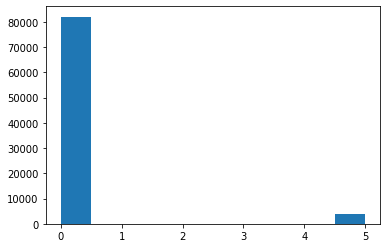

In [35]:
mask=imread(local_mask_dir + '/' + localmasknames[1])
hist=plt.hist(mask.ravel())
# imshow(mask)

###Get and prepare images for training

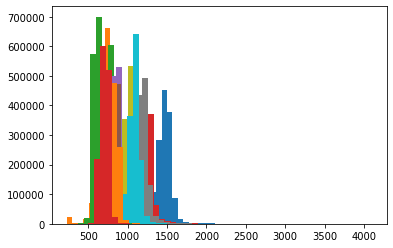

In [26]:
inimagenames = os.listdir(training_images)
# !ls iter1_round1
# print(len(os.listdir(imagesfolder)));
for name in random.sample(inimagenames,max(len(inimagenames)//3,10)):
  if name.endswith('.TIF'):
    image=imread(training_images + '/' + name)
    plt.hist(image.ravel(),50)

In [27]:
minpixelintensity=300 #@param {type:"integer"}
maxpixelintensity=1700 #@param {type:"integer"}

In [28]:
#get images corresponding to masks, put them in 8 bit and rgb
for imagename in os.listdir(training_images):
  print(imagename);
  raw = imread(training_images+'/'+imagename)
  print(raw.ravel())
  bright = rescale_intensity(raw,(minpixelintensity,maxpixelintensity))
  sliced = False;
  if x_slices > 1 or y_slices > 1:
    if context_bounds == [0]*4:
      M = bright.shape[0]/y_slices
      N = bright.shape[1]/x_slices
      if int(M) != M or int(N) != N:
        raise Exception(f"ERROR: Image with size {bright.shape[:1]} cannot be sliced into {x_slices} columns and {y_slices} rows");
      else:
        M = int(M)
        N = int(N)
      sliced = True;
      tiles = [bright[y:y+M,x:x+N] for x in range(0,bright.shape[1],N) for y in range(0,bright.shape[0],M)]
      print(bright.ravel());
      print(tiles[0].shape);
      for num,im in enumerate(tiles):
        print(im.ravel());
        #convert to 8 bit from 16 bit
        bright8b= (im/256).astype('uint8')
        #convert gray to rgb
        bright8b_rgb=np.stack((bright8b,bright8b,bright8b),axis=2)
        imsave(local_image_dir+'/'+os.path.splitext(imagename)[0] + f"-{num}" + ".TIF", bright8b_rgb)
    else:
      M = (bright.shape[0]-context_bounds[0]-context_bounds[2]-crop[0]-crop[2])/y_slices;
      N = (bright.shape[1]-context_bounds[1]-context_bounds[3]-crop[1]-crop[3])/x_slices;
      # print(M,N);
      # print(-context_bounds[1]-context_bounds[3]-crop[1]-crop[3])
      # print(im.shape);
      if int(M) != M or int(N) != N:
        raise Exception(f"ERROR: Mask with size {bright.shape[:2]} cannot be sliced into {x_slices} columns and {y_slices} rows\nwith context bounds of {context_bounds}; {M} and {N} not integers");
      else:
        M = int(M)
        N = int(N)
        sliced = True;
        tiles = [bright[y-context_bounds[0]:y+M+context_bounds[2],x-context_bounds[1]:x+N+context_bounds[3]] 
                for y in range(context_bounds[0]+crop[0],bright.shape[0]-crop[0]-crop[2]-context_bounds[0]-context_bounds[2],M) 
                for x in range(context_bounds[1]+crop[1],bright.shape[1]-crop[1]-crop[3]-context_bounds[1]-context_bounds[3],N)];
        imBounds = [[y-context_bounds[0],y+M+context_bounds[2],x-context_bounds[1],x+N+context_bounds[3]] 
                for y in range(context_bounds[0]+crop[0],bright.shape[0]-crop[0]-crop[2]-context_bounds[0]-context_bounds[2],M) 
                for x in range(context_bounds[1]+crop[1],bright.shape[1]-crop[1]-crop[3]-context_bounds[1]-context_bounds[3],N)];

        # print((context_bounds[0]+crop[0],context_bounds[1]+crop[1]))
        # print(imBounds);
        for num,m in enumerate(tiles):
          print(num);
          bright8b= (m/256).astype('uint8')
          bright8b_rgb=np.stack((bright8b,bright8b,bright8b),axis=2)
          imsave(local_image_dir+'/'+os.path.splitext(imagename)[0] + f"-{num}" + ".TIF", bright8b_rgb)
  else:
    #convert to 8 bit from 16 bit
    bright8b= (bright/256).astype('uint8')
    #convert gray to rgb
    bright8b_rgb=np.stack((bright8b,bright8b,bright8b),axis=2)
    imsave(local_image_dir+'/'+imagename, bright8b_rgb)

random_s8_t51.TIF
[663 657 693 ... 220 214 220]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s8_t51-2.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s8_t51-4.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s8_t51-6.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s8_t51-7.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s8_t51-9.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s8_t51-14.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s8_t51-15.TIF is a low contrast image
/usr/local/lib/pyt

16
17
18
19
20
21
22
23
24
random_s11_t57.TIF


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s8_t51-19.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s8_t51-20.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s8_t51-21.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s8_t51-24.TIF is a low contrast image


[1103 1127 1114 ...  569  576  594]
0
1
2
3
4
5
6
7


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s11_t57-5.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s11_t57-6.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s11_t57-7.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s11_t57-10.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s11_t57-11.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s11_t57-12.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s11_t57-13.TIF is a low contrast image
/usr/loca

8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
random_s4_t63.TIF
[977 999 983 ... 238 230 234]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s4_t63-2.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s4_t63-3.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s4_t63-19.TIF is a low contrast image


15
16
17
18
19
20
21
22
23
24
random_s3_t104.TIF


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s4_t63-24.TIF is a low contrast image


[901 902 895 ... 640 663 638]
0
1
2
3
4
5
6
7
8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s3_t104-4.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s3_t104-6.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s3_t104-7.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s3_t104-11.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s3_t104-12.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s3_t104-13.TIF is a low contrast image


9
10
11
12
13
14
15
16
17
18
19
20

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s3_t104-15.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s3_t104-18.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s3_t104-20.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s3_t104-21.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s3_t104-22.TIF is a low contrast image



21
22
23
24
random_s6_t110.TIF
[907 895 879 ... 533 531 565]
0
1
2
3
4
5
6


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s6_t110-2.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s6_t110-3.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s6_t110-5.TIF is a low contrast image


7
8
9
10
11
12
13
14
15
16
17


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s6_t110-13.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s6_t110-15.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s6_t110-17.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s6_t110-20.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s6_t110-21.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s6_t110-22.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s6_t110-23.TIF is a low contrast image


18
19
20
21
22
23
24
random_s2_t125.TIF
[1173 1171 1183 ...  852  851  860]
0
1
2
3
4
5
6
7
8
9
10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s2_t125-10.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s2_t125-11.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s2_t125-12.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s2_t125-17.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s2_t125-20.TIF is a low contrast image


11
12
13
14
15
16
17
18
19
20
21


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s2_t125-21.TIF is a low contrast image


22
23
24
random_s5_t135.TIF
[964 972 973 ... 704 712 680]
0
1
2
3
4
5
6
7
8
9
10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s5_t135-1.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s5_t135-2.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s5_t135-3.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s5_t135-5.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s5_t135-6.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s5_t135-7.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s5_t135-9.TIF is a low contrast image
/usr/local/li

11
12
13
14
15
16
17
18
19
20
21


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s5_t135-20.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s5_t135-21.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s5_t135-22.TIF is a low contrast image


22
23
24
random_s3_t216.TIF
[952 948 992 ... 696 730 720]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s3_t216-7.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s3_t216-11.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s3_t216-12.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s3_t216-15.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s3_t216-20.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s3_t216-21.TIF is a low contrast image


17
18
19
20
21
22
23
24
migration1_s1_t5.TIF


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s3_t216-22.TIF is a low contrast image


[1050  650  618 ...  783  783  798]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
migration1_s14_t5.TIF


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s1_t5-19.TIF is a low contrast image


[1054 1089 1076 ...  507  501  533]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s14_t5-10.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s14_t5-11.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s14_t5-13.TIF is a low contrast image


23
24
migration1_s9_t6.TIF
[937 940 935 ... 692 717 726]
0
1
2
3
4
5
6
7
8
9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s9_t6-3.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s9_t6-4.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s9_t6-5.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s9_t6-6.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s9_t6-7.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s9_t6-10.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s9_t6-11.TIF is a low contrast ima

10
11
12
13
14
15
16
17
18
19
20
21
22
23
24

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s9_t6-16.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s9_t6-18.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s9_t6-19.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s9_t6-23.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s9_t6-24.TIF is a low contrast image



migration1_s10_t6.TIF
[959 995 965 ... 689 727 701]
0
1
2
3
4
5
6
7
8
9
10
11
12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s10_t6-4.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s10_t6-15.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s10_t6-16.TIF is a low contrast image


13
14
15
16
17
18
19
20
21
22
23
24
migration1_s7_t7.TIF
[988 956 938 ... 697 710 711]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s10_t6-20.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s10_t6-21.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s10_t6-22.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s10_t6-23.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s10_t6-24.TIF is a low contrast image


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s7_t7-19.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s12_t9-2.TIF is a low contrast image


23
24
migration1_s12_t9.TIF
[906 882 883 ... 637 629 656]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s12_t9-10.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s12_t9-11.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s12_t9-16.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s12_t9-17.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s12_t9-18.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s12_t9-21.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s12_t9-22.TIF is a low 

23
24
migration1_s3_t11.TIF
[782 762 744 ... 539 557 552]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s3_t11-0.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s3_t11-5.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s3_t11-9.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s3_t11-10.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s3_t11-22.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s3_t11-23.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s3_t11-24.TIF is a low con

migration1_s4_t48.TIF
[715 695 694 ... 507 499 515]
0
1
2
3
4
5
6
7
8
9
10
11
12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s4_t48-3.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s4_t48-4.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s4_t48-6.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s4_t48-9.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s4_t48-11.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s4_t48-14.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s4_t48-17.TIF is a low cont

13
14
15
16
17
18
19
20
21
22
23
24
random_s11_t119.TIF
[857 864 835 ... 492 525 526]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s11_t119-5.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s11_t119-6.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s11_t119-7.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s11_t119-10.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s11_t119-11.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s11_t119-12.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s11_t119-13.TIF is a low contrast image
/u

22
23
24
random_s1_t138.TIF
[1113 1103 1114 ...  861  879  867]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s1_t138-4.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s1_t138-5.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s1_t138-6.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s1_t138-7.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s1_t138-9.TIF is a low contrast image



17
18
19
20
21
22
23
24
random_s5_t39.TIF
[1230 1229 1177 ...  892  886  860]
0
1
2
3
4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s5_t39-1.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s5_t39-2.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s5_t39-6.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s5_t39-7.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s5_t39-12.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s5_t39-21.TIF is a low contrast image


5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
random_s1_t157.TIF
[1115 1137 1130 ...  874  875  900]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s1_t157-4.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s1_t157-5.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s1_t157-6.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s1_t157-7.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s1_t157-9.TIF is a low contrast image


20
21
22
23
24
random_s6_t220.TIF
[846 846 844 ... 527 511 532]
0
1
2
3
4
5
6
7


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s6_t220-2.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s6_t220-3.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s6_t220-5.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s6_t220-12.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s6_t220-13.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s6_t220-15.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s6_t220-17.TIF is a low contrast image


8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
random_s1_t45.TIF


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s6_t220-20.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s6_t220-22.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s6_t220-23.TIF is a low contrast image


[1029 1027 1024 ...  804  818  855]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
random_s9_t171.TIF


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s1_t45-4.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s1_t45-5.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s1_t45-6.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s1_t45-7.TIF is a low contrast image


[1302 1290 1296 ...  922  926  960]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s9_t171-10.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s9_t171-11.TIF is a low contrast image



21
22
23
24
random_s7_t76.TIF
[926 896 916 ... 600 598 611]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
migration1_s13_t1.TIF
[804 822 817 ... 433 442 448]
0
1
2
3
4
5
6
7
8
9
10
11
12
13


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s7_t76-2.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s7_t76-3.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s7_t76-4.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s7_t76-5.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s7_t76-7.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s7_t76-8.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random_s7_t76-9.TIF is a low contrast image
/usr/local/lib/pytho

14
15
16
17
18
19
20
21
22
23
24
migration1_s8_t20.TIF
[790 816 794 ... 570 581 600]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
migration1_s5_t29.TIF


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s8_t20-0.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s8_t20-1.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s8_t20-7.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s8_t20-11.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s8_t20-12.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s8_t20-13.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s8_t20-14.TIF is a low con

[927 940 934 ... 681 684 694]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
migration1_s11_t49.TIF
[904 943 906 ... 651 646 621]
0
1
2
3
4
5
6
7
8
9
10
11


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s5_t29-2.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s5_t29-6.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s5_t29-12.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s5_t29-13.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s5_t29-14.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s5_t29-16.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s5_t29-17.TIF is a low co

12
13
14
15
16
17
18
19
20
21
22
23
24
migration1_s6_t15.TIF
[956 992 964 ... 675 675 675]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
random2_s16_t8.TIF


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s11_t49-18.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s11_t49-19.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s11_t49-20.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s11_t49-21.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s11_t49-22.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s11_t49-23.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/migration1_s6_t15-2.TIF is a

[1241 1200 1243 ...  928  942  931]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
random2_s14_t34.TIF
[1417 1388 1396 ... 1094 1118 1107]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
random2_s8_t43.TIF
[1246 1272 1271 ...  960  961  952]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
random2_s3_t192.TIF
[1353 1369 1354 ... 1042 1023 1021]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
random2_s14_t83.TIF
[1311 1287 1305 ... 1092 1064 1054]
0
1
2
3
4
5
6
7
8
9
10
11
12
13


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random2_s3_t192-4.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random2_s3_t192-9.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random2_s3_t192-14.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random2_s3_t192-19.TIF is a low contrast image


14
15
16
17
18
19
20
21
22
23
24
random2_s14_t78.TIF
[1304 1304 1324 ... 1072 1077 1075]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
random2_s14_t150.TIF
[1267 1276 1275 ... 1075 1055 1036]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
random2_s10_t28.TIF
[1324 1320 1334 ... 1036 1032 1031]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
random2_s11_t219.TIF
[1263 1289 1259 ...  262  263  270]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
random2_s1_t105.TIF
[1199 1211 1205 ...  899  924  937]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random2_s11_t219-3.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random2_s11_t219-8.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random2_s11_t219-13.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random2_s11_t219-18.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random2_s11_t219-23.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random2_s1_t105-10.TIF is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: local_copy/images/random2_s1_t105-13.TIF is a low contrast im

17
18
19
20
21
22
23
24
random2_s8_t11.TIF
[1321 1337 1341 ...  969 1007  979]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
random2_s2_t38.TIF
[1415 1385 1419 ... 1072 1112 1109]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
random2_s6_t13.TIF
[1594 1558 1596 ... 1189 1254 1223]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


###Prepare fast.ai data loader

In [36]:
path=Path("/"+local_folder)

In [37]:
print(os.listdir(local_image_dir));

['random2_s14_t150-2.TIF', 'random2_s10_t28-20.TIF', 'migration1_s5_t29-10.TIF', 'random_s11_t57-20.TIF', 'migration1_s1_t5-17.TIF', 'migration1_s8_t20-18.TIF', 'random2_s14_t78-5.TIF', 'random_s1_t138-18.TIF', 'random_s7_t76-22.TIF', 'migration1_s11_t49-0.TIF', 'migration1_s8_t20-2.TIF', 'migration1_s6_t15-0.TIF', 'random_s6_t110-17.TIF', 'random_s3_t216-11.TIF', 'random_s7_t76-0.TIF', 'migration1_s14_t5-4.TIF', 'random2_s3_t192-14.TIF', 'migration1_s3_t11-12.TIF', 'random_s3_t216-8.TIF', 'random_s9_t171-22.TIF', 'migration1_s13_t1-22.TIF', 'random2_s14_t150-4.TIF', 'random_s9_t171-24.TIF', 'random2_s14_t150-15.TIF', 'random_s11_t57-15.TIF', 'migration1_s1_t5-5.TIF', 'migration1_s12_t9-22.TIF', 'random_s8_t51-23.TIF', 'random_s11_t119-23.TIF', 'migration1_s5_t29-6.TIF', 'random_s6_t220-13.TIF', 'migration1_s10_t6-17.TIF', 'migration1_s9_t6-24.TIF', 'migration1_s13_t1-6.TIF', 'random_s5_t135-4.TIF', 'random_s6_t110-14.TIF', 'random_s3_t104-1.TIF', 'random2_s6_t13-17.TIF', 'random_s6_t2

In [38]:
path2 = untar_data(URLs.CAMVID_TINY)

In [39]:
codes2 = np.loadtxt(path2/'codes.txt', dtype=str)

In [40]:
codes2

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [41]:
def label_func(x): return path/local_mask_dir/f'{x.stem}.TIF'
codes = np.loadtxt(path2/'codes.txt', dtype=str)

In [42]:
#dls = SegmentationDataLoaders.from_label_func(
#    path, bs=4, fnames = get_image_files(path/'imagesbrightrgb'),
#    label_func = lambda o: path/'masks'/f'{o.stem}.png',
#    codes = np.loadtxt(path2/'codes.txt', dtype=str)
    
#)

In [43]:
#dls = SegmentationDataLoaders.from_label_func(path,fnames,label_func,bs=4,codes=codes)

In [44]:
trainingset = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items = get_image_files,
                   get_y = label_func,
                   splitter=RandomSplitter(),
                   #batch_tfms=aug_transforms(size=(512,672)))
                   batch_tfms=aug_transforms(size=(256,336)))

In [45]:
dls = trainingset.dataloaders(path/local_image_dir, path=path, bs=8);
print(os.listdir(path/local_image_dir));
dls.dataset

['random2_s14_t150-2.TIF', 'random2_s10_t28-20.TIF', 'migration1_s5_t29-10.TIF', 'random_s11_t57-20.TIF', 'migration1_s1_t5-17.TIF', 'migration1_s8_t20-18.TIF', 'random2_s14_t78-5.TIF', 'random_s1_t138-18.TIF', 'random_s7_t76-22.TIF', 'migration1_s11_t49-0.TIF', 'migration1_s8_t20-2.TIF', 'migration1_s6_t15-0.TIF', 'random_s6_t110-17.TIF', 'random_s3_t216-11.TIF', 'random_s7_t76-0.TIF', 'migration1_s14_t5-4.TIF', 'random2_s3_t192-14.TIF', 'migration1_s3_t11-12.TIF', 'random_s3_t216-8.TIF', 'random_s9_t171-22.TIF', 'migration1_s13_t1-22.TIF', 'random2_s14_t150-4.TIF', 'random_s9_t171-24.TIF', 'random2_s14_t150-15.TIF', 'random_s11_t57-15.TIF', 'migration1_s1_t5-5.TIF', 'migration1_s12_t9-22.TIF', 'random_s8_t51-23.TIF', 'random_s11_t119-23.TIF', 'migration1_s5_t29-6.TIF', 'random_s6_t220-13.TIF', 'migration1_s10_t6-17.TIF', 'migration1_s9_t6-24.TIF', 'migration1_s13_t1-6.TIF', 'random_s5_t135-4.TIF', 'random_s6_t110-14.TIF', 'random_s3_t104-1.TIF', 'random2_s6_t13-17.TIF', 'random_s6_t2

(#840) [(PILImage mode=RGB size=336x256, PILMask mode=L size=336x256),(PILImage mode=RGB size=336x256, PILMask mode=L size=336x256),(PILImage mode=RGB size=336x256, PILMask mode=L size=336x256),(PILImage mode=RGB size=336x256, PILMask mode=L size=336x256),(PILImage mode=RGB size=336x256, PILMask mode=L size=336x256),(PILImage mode=RGB size=336x256, PILMask mode=L size=336x256),(PILImage mode=RGB size=336x256, PILMask mode=L size=336x256),(PILImage mode=RGB size=336x256, PILMask mode=L size=336x256),(PILImage mode=RGB size=336x256, PILMask mode=L size=336x256),(PILImage mode=RGB size=336x256, PILMask mode=L size=336x256)...]

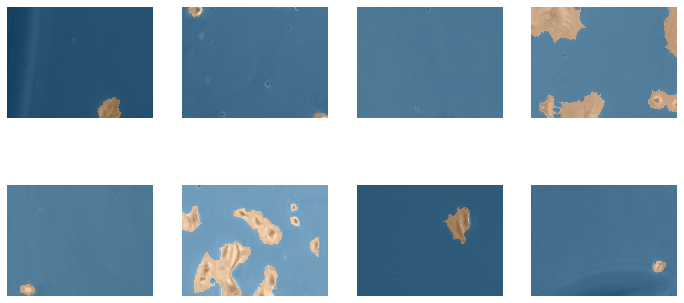

In [47]:
dls.show_batch(max_n=10)

#Training

In [48]:
#learn = unet_learner(dls, resnet34)
loadedlearner=load_learner(modelsfolder + '/' + inmodelname,cpu=True)
loadedlearner.dls=dls

In [ ]:
#learn.fine_tune(8)
loadedlearner.fine_tune(10)


epoch,train_loss,valid_loss,time


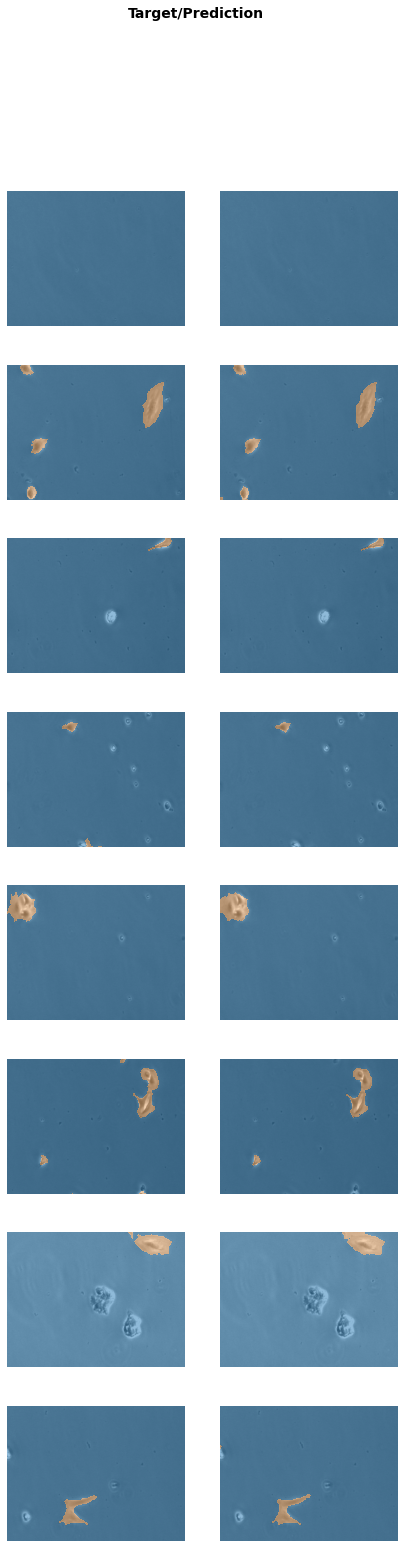

In [ ]:
n = 16
loadedlearner.show_results(max_n=n, figsize=(7,25))

In [ ]:
loadedlearner.export(fname=modelsfolder + '/' + outmodelname, pickle_protocol=2)

# Loading a trained model

#Segment experiment

### Set contrast range

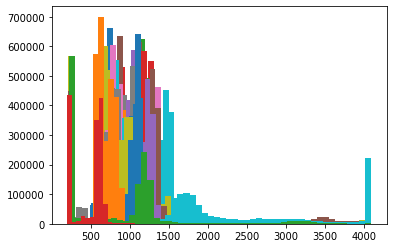

In [ ]:
imagenames=os.listdir(folderimages)
for i in range(1,len(imagenames)):
  if imagenames[i][-3:]=='TIF':
    image=imread(folderimages + '/'+imagenames[i])
    plt.hist(image.ravel(),50)

In [ ]:
minpixelintensity=300 #@param {type:"integer"}
maxpixelintensity=1500 #@param {type:"integer"}

### Loading a trained model

In [ ]:
## ONLY CELL MODEL

# !gsutil cp gs://{bucketname}/fastai_unet_models/{modelname} /{local_folder}
path=Path('/' + local_folder)

predictionSet = torchvision.datasets.ImageFolder(root=path/local_segmentation_input_dir)
# DataBlock(blocks=(ImageBlock),
#                    get_items = get_image_files,
#                    splitter=RandomSplitter(),
#                    #batch_tfms=aug_transforms(size=(512,672)))
#                    batch_tfms=aug_transforms(size=(256,336)))

import multiprocessing
print(multiprocessing.cpu_count());

dls = predictionSet.dataloaders(path/local_segmentation_input_dir, path=path, bs=8,num_workers=multiprocessing.cpu_count())

path2 = untar_data(URLs.CAMVID_TINY)
loadedlearner=load_learner(modelname,cpu=True)
loadedlearner.dls = dls;

###Test segmentation

In [ ]:
for i in range(min(5,len(imagenames))):
  if imagenames[i][-3:]=='TIF':
    bright = rescale_intensity(imread(folderimages+'/'+imagenames[i]),(minpixelintensity,maxpixelintensity))
    sliced = False;
    if x_slices > 1 or y_slices > 1:
      if context_bounds == [0]*4:
        M = bright.shape[0]/x_slices
        N = bright.shape[1]/y_slices
        if int(M) != M or int(N) != N:
          raise Exception(f"ERROR: Input image with size {bright.shape[:1]} cannot be sliced into {x_slices} columns and {y_slices} rows");
        else:
          M = int(M)
          N = int(N)
        sliced = True;
        tiles = [bright[x:x+M,y:y+N] for x in range(0,bright.shape[0],M) for y in range(0,bright.shape[1],N)]
        outMasks = [];
        for num,im in enumerate(tiles):
          #convert to 8 bit from 16 bit
          bright8b= (im/256).astype('uint8')
          #convert gray to rgb
          to_segment=np.stack((bright8b,bright8b,bright8b),axis=2)
          segmented = loadedlearner.predict(to_segment)[1]
          mask01=np.asarray(segmented)
          outMasks.append(mask01);
        stitched = np.concatenate([np.concatenate(outMasks[i*x_slices:(i+1)*x_slices],axis=1) for i in range(y_slices)]);
        imsave(foldermasks+'/'+imagenames[i], stitched.astype('uint8'))
      else:
        M = (bright.shape[0]-context_bounds[0]-context_bounds[2]-crop[0]-crop[2])/y_slices;
        N = (bright.shape[1]-context_bounds[1]-context_bounds[3]-crop[1]-crop[3])/x_slices;
        # print(M,N);
        # print(-context_bounds[1]-context_bounds[3]-crop[1]-crop[3])
        # print(im.shape);
        if int(M) != M or int(N) != N:
          raise Exception(f"ERROR: Mask with size {bright.shape[:2]} cannot be sliced into {x_slices} columns and {y_slices} rows\nwith context bounds of {context_bounds}; {M} and {N} not integers");
        else:
          M = (bright.shape[0]-context_bounds[0]-context_bounds[2]-crop[0]-crop[2])/y_slices;
        N = (bright.shape[1]-context_bounds[1]-context_bounds[3]-crop[1]-crop[3])/x_slices;
        # print(M,N);
        # print(-context_bounds[1]-context_bounds[3]-crop[1]-crop[3])
        # print(im.shape);
        if int(M) != M or int(N) != N:
          raise Exception(f"ERROR: Mask with size {bright.shape[:2]} cannot be sliced into {x_slices} columns and {y_slices} rows\nwith context bounds of {context_bounds}; {M} and {N} not integers");
        else:
          M = int(M)
          N = int(N)
          tiles = [bright[y-context_bounds[0]:y+M+context_bounds[2],x-context_bounds[1]:x+N+context_bounds[3]] 
                  for y in range(context_bounds[0]+crop[0],bright.shape[0]-crop[0]-crop[2]-context_bounds[0]-context_bounds[2],M) 
                  for x in range(context_bounds[1]+crop[1],bright.shape[1]-crop[1]-crop[3]-context_bounds[1]-context_bounds[3],N)];
          imBounds = [[y-context_bounds[0],y+M+context_bounds[2],x-context_bounds[1],x+N+context_bounds[3]] 
                  for y in range(context_bounds[0]+crop[0],bright.shape[0]-crop[0]-crop[2]-context_bounds[0]-context_bounds[2],M) 
                  for x in range(context_bounds[1]+crop[1],bright.shape[1]-crop[1]-crop[3]-context_bounds[1]-context_bounds[3],N)];

          # print((context_bounds[0]+crop[0],context_bounds[1]+crop[1]))
          # print(imBounds);
          stitchMasks = [];
          for num,m in enumerate(tiles):
            print(num);
            bright8b= (m/256).astype('uint8')
            bright8b_rgb=np.stack((bright8b,bright8b,bright8b),axis=2)
            segmented = loadedlearner.predict(bright8b_rgb)[1];
            mask01 = np.asarray(segmented);
            x = num // y_slices;
            y = num % x_slices;
            imBounds2 = [crop[0]+context_bounds[0] if x != 0 else 0,mask01.shape[0]-crop[2]-context_bounds[2] if x != x_slices-1 else mask01.shape[0],crop[1]+context_bounds[1] if y!= 0 else 0 ,mask01.shape[1]-crop[3]-context_bounds[3] if y != y_slices - 1 else mask01.shape[1]];
            stitchMasks.append(mask01[imBounds2[0]:imBounds2[1],imBounds2[2]:imBounds2[3]]);
            # stitchMasks.append(mask01[crop[0]+context_bounds[0]:mask01.shape[0]-crop[2]-context_bounds[2],crop[1]+context_bounds[1]:mask01.shape[1]-crop[3]-context_bounds[3]]);
          stitched = np.concatenate([np.concatenate(stitchMasks[i*x_slices:(i+1)*x_slices],axis=1) for i in range(y_slices)]);
          print(stitched.shape);
          imsave(foldermasks+'/'+imagenames[i], stitched.astype('uint8'));
    else:
      #convert to 8 bit from 16 bit
      bright8b= (bright/256).astype('uint8')
      #convert gray to rgb
      to_segment=np.stack((bright8b,bright8b,bright8b),axis=2)
      segmented = loadedlearner.predict(to_segment)[1]
      mask01=np.asarray(segmented)
      imsave(foldermasks+'/'+imagenames[i], mask01.astype('uint8'))
    
    # bright = rescale_intensity(imread(filenamebase+'/'+imagenames[i]),(minpixelintensity,maxpixelintensity))
    # #convert to 8 bit from 16 bit
    # bright8b= (bright/256).astype('uint8')
    # tosegment=np.stack((bright8b,bright8b,bright8b),axis=2)
    # segmented = loadedlearner.predict(tosegment)[1]
    # mask01=np.asarray(segmented)
    # imsave(foldermasks+'/'+imagenames[i], mask01.astype('uint8'))

25
(960, 1260)


Exception: ignored

In [ ]:
masknames=os.listdir(foldermasks)
nimages=len(masknames)
f, axarr = plt.subplots(nimages,2)

for i in range(nimages):
  mask=imread(foldermasks+'/'+masknames[i])
  image=rescale_intensity(imread(folderimages+'/'+masknames[i]),(minpixelintensity,maxpixelintensity))

  axarr[i,0].imshow(image)
  axarr[i,1].imshow(mask)    
  f.set_size_inches(10,5*nimages)

<Figure size 432x288 with 0 Axes>

###Segment experiment and save output

In [ ]:
        dl = self.dls.test_dl([item], rm_type_tfms=rm_type_tfms, num_workers=0)
        inp,preds,_,dec_preds = self.get_preds(dl=dl, with_input=True, with_decoded=True)
        i = getattr(self.dls, 'n_inp', -1)
        inp = (inp,) if i==1 else tuplify(inp)
        dec = self.dls.decode_batch(inp + tuplify(dec_preds))[0]
        dec_inp,dec_targ = map(detuplify, [dec[:i],dec[i:]])
        res = dec_targ,dec_preds[0],preds[0]
        if with_input: res = (dec_inp,) + res
        return res
        
for name in imagenames:
  print(name);
  if name[-3:]=='TIF':
    bright = rescale_intensity(imread(folderimages+'/'+name),(minpixelintensity,maxpixelintensity))
    sliced = False;
    if x_slices > 1 or y_slices > 1:
      if context_bounds == [0]*4:
        M = bright.shape[0]/x_slices
        N = bright.shape[1]/y_slices
        if int(M) != M or int(N) != N:
          raise Exception(f"ERROR: Input image with size {bright.shape[:1]} cannot be sliced into {x_slices} columns and {y_slices} rows");
        else:
          M = int(M)
          N = int(N)
        sliced = True;
        tiles = [bright[x:x+M,y:y+N] for x in range(0,bright.shape[0],M) for y in range(0,bright.shape[1],N)]
        outMasks = [];
        for num,im in enumerate(tiles):
          #convert to 8 bit from 16 bit
          bright8b= (im/256).astype('uint8')
          #convert gray to rgb
          to_segment=np.stack((bright8b,bright8b,bright8b),axis=2)
          segmented = loadedlearner.predict(to_segment)[1]
          mask01=np.asarray(segmented)
          outMasks.append(mask01);
        stitched = np.concatenate([np.concatenate(outMasks[i*x_slices:(i+1)*x_slices],axis=1) for i in range(y_slices)]);
        imsave(foldermasks+'/'+name, stitched.astype('uint8'))
      else:
        M = (bright.shape[0]-context_bounds[0]-context_bounds[2]-crop[0]-crop[2])/y_slices;
        N = (bright.shape[1]-context_bounds[1]-context_bounds[3]-crop[1]-crop[3])/x_slices;
        # print(M,N);
        # print(-context_bounds[1]-context_bounds[3]-crop[1]-crop[3])
        # print(im.shape);
        if int(M) != M or int(N) != N:
          raise Exception(f"ERROR: Mask with size {bright.shape[:2]} cannot be sliced into {x_slices} columns and {y_slices} rows\nwith context bounds of {context_bounds}; {M} and {N} not integers");
        else:
          M = int(M)
          N = int(N)
          tiles = [bright[y-context_bounds[0]:y+M+context_bounds[2],x-context_bounds[1]:x+N+context_bounds[3]] 
                  for y in range(context_bounds[0]+crop[0],bright.shape[0]-crop[0]-crop[2]-context_bounds[0]-context_bounds[2],M) 
                  for x in range(context_bounds[1]+crop[1],bright.shape[1]-crop[1]-crop[3]-context_bounds[1]-context_bounds[3],N)];
          imBounds = [[y-context_bounds[0],y+M+context_bounds[2],x-context_bounds[1],x+N+context_bounds[3]] 
                  for y in range(context_bounds[0]+crop[0],bright.shape[0]-crop[0]-crop[2]-context_bounds[0]-context_bounds[2],M) 
                  for x in range(context_bounds[1]+crop[1],bright.shape[1]-crop[1]-crop[3]-context_bounds[1]-context_bounds[3],N)];

          # print((context_bounds[0]+crop[0],context_bounds[1]+crop[1]))
          # print(imBounds);
          stitchMasks = [];
          for num,m in enumerate(tiles):
            print(num);
            bright8b= (m/256).astype('uint8')
            bright8b_rgb=np.stack((bright8b,bright8b,bright8b),axis=2)
            segmented = loadedlearner.predict(bright8b_rgb)[1];
            mask01 = np.asarray(segmented);
            x = num // y_slices;
            y = num % x_slices;
            imBounds2 = [crop[0]+context_bounds[0] if x != 0 else 0,mask01.shape[0]-crop[2]-context_bounds[2] if x != x_slices-1 else mask01.shape[0],crop[1]+context_bounds[1] if y!= 0 else 0 ,mask01.shape[1]-crop[3]-context_bounds[3] if y != y_slices - 1 else mask01.shape[1]];
            stitchMasks.append(mask01[imBounds2[0]:imBounds2[1],imBounds2[2]:imBounds2[3]]);
            # stitchMasks.append(mask01[crop[0]+context_bounds[0]:mask01.shape[0]-crop[2]-context_bounds[2],crop[1]+context_bounds[1]:mask01.shape[1]-crop[3]-context_bounds[3]]);
          stitched = np.concatenate([np.concatenate(stitchMasks[i*x_slices:(i+1)*x_slices],axis=1) for i in range(y_slices)]);
          print(stitched.shape);
          print(f"saving context-stitched mask {name} with shape {stitched.shape}");
          imsave(foldermasks+'/'+name, stitched.astype('uint8'));
    else:

      #convert to 8 bit from 16 bit
      bright8b= (bright/256).astype('uint8')
      #convert gray to rgb
      to_segment=np.stack((bright8b,bright8b,bright8b),axis=2)
      segmented = loadedlearner.predict(to_segment)[1]
      mask01=np.asarray(segmented)
      print(f"saving unstitched mask {name} with shape {mask01.shape}");
      imsave(foldermasks+'/'+name, mask01.astype('uint8'))

migration1_s1_t5.TIF
0


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask migration1_s1_t5.TIF with shape (256, 336)
migration1_s6_t15.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/migration1_s1_t5.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask migration1_s6_t15.TIF with shape (256, 336)
random2_s14_t78.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/migration1_s6_t15.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask random2_s14_t78.TIF with shape (256, 336)
random2_s8_t43.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/random2_s14_t78.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask random2_s8_t43.TIF with shape (256, 336)
migration1_s10_t6.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/random2_s8_t43.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask migration1_s10_t6.TIF with shape (256, 336)
random_s4_t63.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/migration1_s10_t6.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask random_s4_t63.TIF with shape (256, 336)
migration1_s9_t6.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/random_s4_t63.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask migration1_s9_t6.TIF with shape (256, 336)
random2_s14_t34.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/migration1_s9_t6.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask random2_s14_t34.TIF with shape (256, 336)
random_s1_t45.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/random2_s14_t34.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask random_s1_t45.TIF with shape (256, 336)
random_s3_t216.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/random_s1_t45.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask random_s3_t216.TIF with shape (256, 336)
random2_s6_t13.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/random_s3_t216.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask random2_s6_t13.TIF with shape (256, 336)
random_s11_t119.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/random2_s6_t13.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask random_s11_t119.TIF with shape (256, 336)
random_s6_t110.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/random_s11_t119.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask random_s6_t110.TIF with shape (256, 336)
migration1_s11_t49.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/random_s6_t110.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask migration1_s11_t49.TIF with shape (256, 336)
random2_s10_t28.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/migration1_s11_t49.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask random2_s10_t28.TIF with shape (256, 336)
random_s2_t125.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/random2_s10_t28.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask random_s2_t125.TIF with shape (256, 336)
random2_s16_t8.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/random_s2_t125.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask random2_s16_t8.TIF with shape (256, 336)
migration1_s3_t11.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/random2_s16_t8.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask migration1_s3_t11.TIF with shape (256, 336)
random2_s3_t192.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/migration1_s3_t11.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask random2_s3_t192.TIF with shape (256, 336)
random2_s4_t131.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/random2_s3_t192.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask random2_s4_t131.TIF with shape (256, 336)
random_s11_t57.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/random2_s4_t131.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask random_s11_t57.TIF with shape (256, 336)
migration1_s13_t1.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/random_s11_t57.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask migration1_s13_t1.TIF with shape (256, 336)
random_s5_t135.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/migration1_s13_t1.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask random_s5_t135.TIF with shape (256, 336)
random2_s14_t150.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/random_s5_t135.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask random2_s14_t150.TIF with shape (256, 336)
random_s6_t220.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/random2_s14_t150.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask random_s6_t220.TIF with shape (256, 336)
random_s1_t138.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/random_s6_t220.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask random_s1_t138.TIF with shape (256, 336)
random2_s2_t38.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/random_s1_t138.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask random2_s2_t38.TIF with shape (256, 336)
migration1_s7_t7.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/random2_s2_t38.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask migration1_s7_t7.TIF with shape (256, 336)
random_s1_t157.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/migration1_s7_t7.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask random_s1_t157.TIF with shape (256, 336)
migration1_s8_t20.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/random_s1_t157.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask migration1_s8_t20.TIF with shape (256, 336)
migration1_s5_t29.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/migration1_s8_t20.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask migration1_s5_t29.TIF with shape (256, 336)
random2_s1_t105.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/migration1_s5_t29.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask random2_s1_t105.TIF with shape (256, 336)
migration1_s4_t48.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/random2_s1_t105.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask migration1_s4_t48.TIF with shape (256, 336)
random_s9_t171.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/migration1_s4_t48.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask random_s9_t171.TIF with shape (256, 336)
random2_s8_t11.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/random_s9_t171.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask random2_s8_t11.TIF with shape (256, 336)
random2_s14_t83.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/random2_s8_t11.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask random2_s14_t83.TIF with shape (256, 336)
random2_s13_t200.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/random2_s14_t83.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask random2_s13_t200.TIF with shape (256, 336)
migration1_s12_t9.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/random2_s13_t200.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask migration1_s12_t9.TIF with shape (256, 336)
random_s3_t104.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/migration1_s12_t9.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask random_s3_t104.TIF with shape (256, 336)
migration1_s14_t5.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/random_s3_t104.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask migration1_s14_t5.TIF with shape (256, 336)
random2_s5_t169.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/migration1_s14_t5.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask random2_s5_t169.TIF with shape (256, 336)
random_s5_t39.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/random2_s5_t169.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask random_s5_t39.TIF with shape (256, 336)
random_s7_t76.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/random_s5_t39.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask random_s7_t76.TIF with shape (256, 336)
random2_s11_t219.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/random_s7_t76.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask random2_s11_t219.TIF with shape (256, 336)
random_s8_t51.TIF
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/random2_s11_t219.TIF is a low contrast image


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


20


21


22


23


24


(1024, 1344)
saving context-stitched mask random_s8_t51.TIF with shape (256, 336)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: iter1_masks/random_s8_t51.TIF is a low contrast image


(1024, 1344)


/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


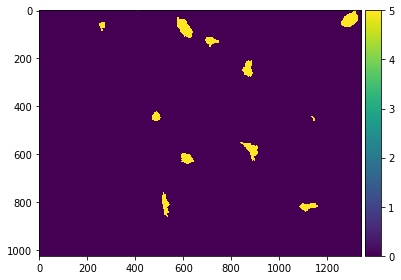

In [ ]:
#check integrity of stitching
savedmasks = os.listdir(foldermasks);
name = random.choice(savedmasks);
mask = imread(foldermasks + '/' +name)
imshow(mask)
print(mask.shape);

In [ ]:
!ls {foldermasks}

migration1_s10_t6.TIF	random2_s13_t200.TIF  random_s11_t57.TIF
migration1_s11_t49.TIF	random2_s14_t150.TIF  random_s1_t138.TIF
migration1_s12_t9.TIF	random2_s14_t34.TIF   random_s1_t157.TIF
migration1_s13_t1.TIF	random2_s14_t78.TIF   random_s1_t45.TIF
migration1_s14_t5.TIF	random2_s14_t83.TIF   random_s2_t125.TIF
migration1_s1_t5.TIF	random2_s16_t8.TIF    random_s3_t104.TIF
migration1_s3_t11.TIF	random2_s1_t105.TIF   random_s3_t216.TIF
migration1_s4_t48.TIF	random2_s2_t38.TIF    random_s4_t63.TIF
migration1_s5_t29.TIF	random2_s3_t192.TIF   random_s5_t135.TIF
migration1_s6_t15.TIF	random2_s4_t131.TIF   random_s5_t39.TIF
migration1_s7_t7.TIF	random2_s5_t169.TIF   random_s6_t110.TIF
migration1_s8_t20.TIF	random2_s6_t13.TIF    random_s6_t220.TIF
migration1_s9_t6.TIF	random2_s8_t11.TIF    random_s7_t76.TIF
random2_s10_t28.TIF	random2_s8_t43.TIF    random_s8_t51.TIF
random2_s11_t219.TIF	random_s11_t119.TIF   random_s9_t171.TIF


In [ ]:
!zip -r {foldermasks}.zip {foldermasks}

updating: iter1_masks/ (stored 0%)
updating: iter1_masks/migration1_s1_t5.TIF (deflated 100%)
updating: iter1_masks/random_s4_t63.TIF (deflated 100%)
updating: iter1_masks/migration1_s9_t6.TIF (deflated 100%)
updating: iter1_masks/random2_s14_t34.TIF (deflated 99%)
updating: iter1_masks/random_s1_t45.TIF (deflated 100%)
updating: iter1_masks/random_s3_t216.TIF (deflated 100%)
updating: iter1_masks/random2_s6_t13.TIF (deflated 100%)
updating: iter1_masks/random_s11_t119.TIF (deflated 100%)
updating: iter1_masks/random_s6_t110.TIF (deflated 100%)
updating: iter1_masks/migration1_s11_t49.TIF (deflated 100%)
updating: iter1_masks/random2_s10_t28.TIF (deflated 99%)
updating: iter1_masks/random_s2_t125.TIF (deflated 100%)
updating: iter1_masks/random2_s16_t8.TIF (deflated 100%)
updating: iter1_masks/migration1_s3_t11.TIF (deflated 100%)
updating: iter1_masks/random2_s3_t192.TIF (deflated 100%)
updating: iter1_masks/random2_s4_t131.TIF (deflated 100%)
updating: iter1_masks/random_s11_t57.TIF 

In [ ]:
!gsutil -m cp /{local_folder}/{foldermasks}.zip gs://{dest_path}  

Copying file:///content/iter1_masks.zip [Content-Type=application/zip]...
/ [1/1 files][296.8 KiB/296.8 KiB] 100% Done                                    
Operation completed over 1 objects/296.8 KiB.                                    


In [ ]:
dest_path

'optotaxisbucket/optotraining_output/iter1_round6'